# <span style="color:#900C3F"> Laboratorio di Simulazione Numerica</span>

# <span style="color: #C70039 "> Esercitazione 10</span>

### <span style="color: #FF5733 "> Esercizio 10.1</span>

Ho scritto un codice per risolvere il problema del TSP con un algoritmo di *simulated annealing*.  
Il funzionamento del *simulated annealing* si comprende in modo chiaro se guardato in analogia con la termodinamica. Si pensi al raffreddamento di un liquido: al alta temperatura, le molecole del liquido si muovono liberamente. Abbassando la temperatura lentamente, si forma un cristallo molto ordinato (configurazione a bassissima energia potenziale); se la temperatura viene invece abbassata in modo brusco, il sistema viene congelato prima che riesca a raggiungere la configurazione di minima energia e si creano delle impurezze. È quindi di fondamentale importanza che il processo di raffreddamento avvenga lentamente.  
Nel problema del TSP, possiamo interpretare le diverse possibili realizzazioni del percorso come i diversi possibili stati del sistema e la lunghezza (o la lunghezza quadratica) del percorso proposto come funzione costo (cioè come energia).  
Se considero poi gli stati distribuiti secondo Boltzmann ($p(x)=e^{\frac{-\beta L(x)}{Z}}$), ho che a basse temperature la distribuzione è centrata nel minimo di $L(x)$. Si tratta quindi di campionare la distribuzione di Boltzmann e per farlo posso usare l'algoritmo di Metropolis. In particolare, posso far variare la temperatura (abbassandola lentamente) e ad ogni fissato valore di $\beta$ fare alcuni step di campionamento usando il Metropolis: genero una nuova configurazione $x'$ applicando alcune mutazioni e la nuova configurazione sostituisce la vecchia con probabilità data da $e^{-\beta(L(x')-L(x))}$ se $L(x') > L(x)$, 1 altrimenti. Questo processo porta a trovare la configurazione che minimizza *L(x)*.  

**Il mio codice:** 
Il codice che ho scritto è strutturato nel modo seguente:  
Da file in input vengono letti il numero di città che si desidera visitare, una variabile che discrimina tra città distribuite sul cerchio o nel quadrato, la temperatura di partenza, il numero di blocchi e il numero di step nel primo blocco. Vengono poi riempiti gli array che contengono le coordinate delle città da visitare. L'oggetto più importante all'interno del codice è un oggetto di tipo Individuo (si veda l'Esercitazione 9 per la descrizione della classe *Individuo*) che durante tutto il codice rappresenta la configurazione attuale del sistema. Inizio poi a ciclare sui blocchi. Ad ogni blocco la temperatura viene moltiplicata per il fattore 0.9 e il numero di step del blocco viene ottenuto come il numero di step nel primo blocco moltiplicato per l'indice del blocco attuale (in questo modo eseguo meno step dell'algoritmo quando sono ad alta temperatura e gli step aumentano man mano che diminuisce la temperatura). Per ogni step all'interno del blocco propongo le seguenti mutazioni (che vengono accettate o meno dal Metropolis, come descritto sopra):  
- permutazione di due elementi dell'individuo (scambio di due città)
- la traslazione del percorso
- il capovolgimento di un pezzo del percorso
- la permutazione tra due pezzi di percorso  

Al termine di ogni blocco stampo su file di output la Lunghezza proposta dall'individuo in quel momento. Al termine di tutti i blocchi, stampo su file di output il percorso proposto dall'individuo, che, se il *simulated annealing* ha funzionato, rappresenta il minimo percorso possibile.  
Si riportano di seguiti di dati ottenuti, con $T_{iniziale}$=15, 100 blocchi e 100 step nel primo blocco

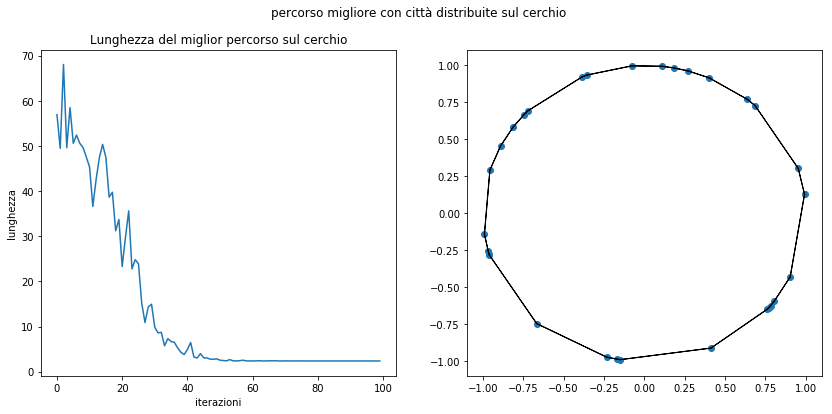

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
n, p= np.loadtxt("es10.1/cerchio/lunghezza.dat", usecols=(0,1), delimiter='\t', unpack='true')
plt.plot(n,p)
plt.xlabel('iterazioni')
plt.ylabel('lunghezza')
plt.title('Lunghezza del miglior percorso sul cerchio')

plt.subplot(1,2,2)
x,y=np.loadtxt("es10.1/cerchio/percorso_migliore.dat", usecols=(0,1), delimiter='\t', unpack='true')
plt.suptitle("percorso migliore con città distribuite sul cerchio")
plt.scatter(x,y)
for i in range(0,29):
    plt.arrow(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i])
    
plt.arrow(x[29], y[29], x[0]-x[29], y[0]-y[29])

plt.show()

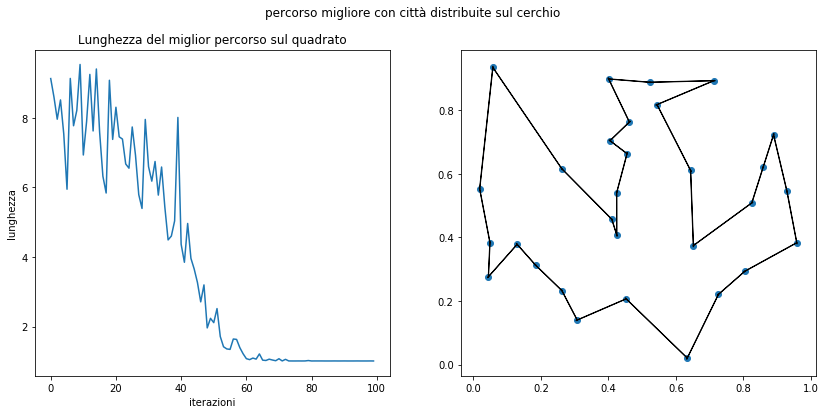

In [16]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
n, p= np.loadtxt("es10.1/quadrato/lunghezza.dat", usecols=(0,1), delimiter='\t', unpack='true')
plt.plot(n,p)
plt.xlabel('iterazioni')
plt.ylabel('lunghezza')
plt.title('Lunghezza del miglior percorso sul quadrato')

plt.subplot(1,2,2)
x,y=np.loadtxt("es10.1/quadrato/percorso_migliore.dat", usecols=(0,1), delimiter='\t', unpack='true')
plt.suptitle("percorso migliore con città distribuite sul cerchio")
plt.scatter(x,y)
for i in range(0,29):
    plt.arrow(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i])
    
plt.arrow(x[29], y[29], x[0]-x[29], y[0]-y[29])

plt.show()

### <span style="color: #FF5733 "> Esercizio 10.2</span>

Ho utilizzato la libreria MPI per parallerizzare il codice che esegue *simulated annealing*.  
Ho sfruttato il fatto che ad ogni processo sia associato un valore della variabile *rank* diverso per fare in modo che ogni processo legga valori diversi dal file *Primes* (se non mi fossi curata di questo, ogni simulazione genererebbe gli stessi numeri casuali e non avrei simulazioni diverse in parallelo, ma la stessa identica simulazione ripetuta in parallelo, che sarebbe inutile). Ho realizzato l'estrazione delle coordinate delle città da visitare solo nel processo associato a *rank=0* e ho poi copiato i vettori contenenti le coordinate delle città dal processo con *rank=0* a tutti gli altri. Questa operazione è necessaria per evitare che (appunto perchè ogni simulazione lavora con sequenze di numeri casuali diverse) ogni simulazione generi distribuzioni delle città diverse e si trovino quindi diversi ottimi di configurazioni diverse (quello che si vuole fare è invece fare diverse simulazioni in parallelo per ottimizzare lo stesso sistema). Ho poi eseguito l'algoritmo di *simulated annealing*. Alla fine di ogni blocco salvo la lunghezza quadratica proposta dall'individuo attuale su di un vettore.  
Ho poi creato la struct *Dati*, che contiene un double e un intero. Alla fine del ciclo sui blocchi ho salvato in un oggetto di tipo *Dati* la lunghezza quadratica del percorso proposto e il valore di *rank*. Ho poi creato nel codice un'ulteriore oggetto di tipo *Dati*, per salvare poi le informazioni relative al miglior risultato delle simulazioni. Ho cercato tramite la funzione *MPI_Reduce* quale fosse il processo che ha generato il percorso più breve. Ho infine stampato su file di output la lunghezza quadratica in funzione del blocco e il percorso finale prodotti dal processo miagliore. Si mostrano di seguito i risultati ottenuti:

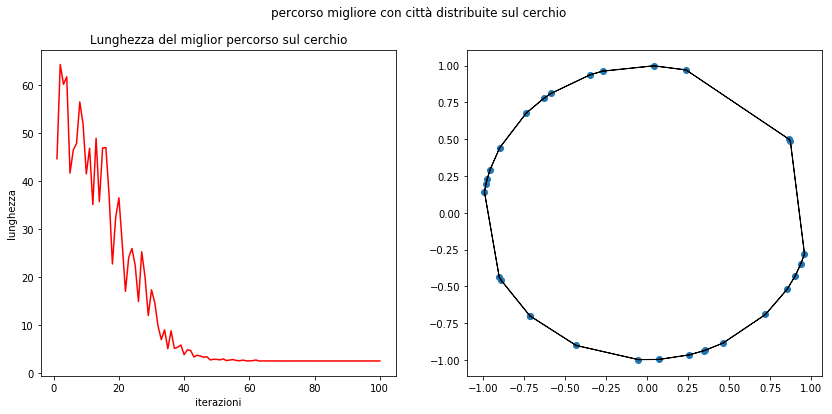

In [23]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
n, p= np.loadtxt("parallelo/cerchio/lunghezza.dat", usecols=(0,1), delimiter='\t', unpack='true')
plt.plot(n,p, color="r")
plt.xlabel('iterazioni')
plt.ylabel('lunghezza')
plt.title('Lunghezza del miglior percorso sul cerchio')

plt.subplot(1,2,2)
x,y=np.loadtxt("parallelo/cerchio/percorso_migliore.dat", usecols=(0,1), delimiter='\t', unpack='true')
plt.suptitle("percorso migliore con città distribuite sul cerchio")
plt.scatter(x,y)
for i in range(0,29):
    plt.arrow(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i])
    
plt.arrow(x[29], y[29], x[0]-x[29], y[0]-y[29])

plt.show()

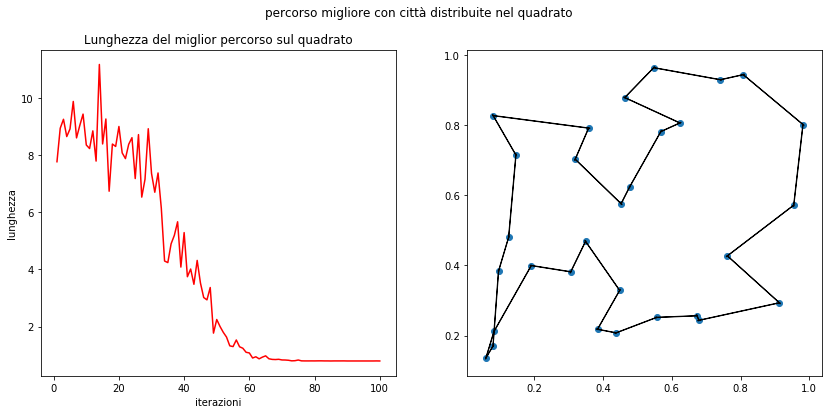

In [20]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
n, p= np.loadtxt("parallelo/quadrato/lunghezza.dat", usecols=(0,1), delimiter='\t', unpack='true')
plt.plot(n,p, color="r")
plt.xlabel('iterazioni')
plt.ylabel('lunghezza')
plt.title('Lunghezza del miglior percorso sul quadrato')

plt.subplot(1,2,2)
x,y=np.loadtxt("parallelo/quadrato/percorso_migliore.dat", usecols=(0,1), delimiter='\t', unpack='true')
plt.suptitle("percorso migliore con città distribuite nel quadrato")
plt.scatter(x,y)
for i in range(0,29):
    plt.arrow(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i])
    
plt.arrow(x[29], y[29], x[0]-x[29], y[0]-y[29])

plt.show()